In [1]:
import requests
import numpy as np
from astropy.time import Time
from astropy.coordinates import EarthLocation
import astropy.units as u
from astropy.coordinates import AltAz, SkyCoord
from datetime import datetime, timedelta
import re
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams["font.size"] = 15
rcParams["axes.linewidth"] = 3
rcParams['xtick.top'] = True
rcParams['ytick.right'] = True
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'
rcParams['xtick.major.size'] = 10
rcParams['xtick.major.width'] = 2
rcParams['xtick.minor.size'] = 5
rcParams['xtick.minor.width'] = 2
rcParams['ytick.major.size'] = 10
rcParams['ytick.major.width'] = 2
rcParams['ytick.minor.size'] = 5
rcParams['ytick.minor.width'] = 2

import pytz
aflica = pytz.timezone('Africa/Johannesburg')

url1 = "http://primeenv.saao.ac.za/tobedone.dat"
url2 = "http://192.168.212.11/tobedone.dat"

try:
    response = requests.get(url1)
except:
    response = requests.get(url2) 

data = response.text

tmp =  data.split("\n")
del tmp[0:2]
del tmp[len(tmp)-1]


field_num_list, field_ra_list, field_dec_list = [], [], []
for line in tmp:
    line = line.strip().split()
    line[0] = re.sub(r'[^0-9]', '', line[0])
    field_num_list.append(int(line[0]))
    field_ra_list.append(float(line[1]))
    field_dec_list.append(float(line[2]))

field_num_list, field_ra_list, field_dec_list = np.array(field_num_list), np.array(field_ra_list), np.array(field_dec_list)
field_array = np.empty(field_num_list.shape[0], dtype=[("num", int), ("ra", float), ("dec", float),("alt",float),("az",float)])
field_array["num"], field_array["ra"], field_array["dec"] = field_num_list, field_ra_list, field_dec_list
field_array["ra"] *= 360/24
obs_loc = EarthLocation(lat=-32.3763*u.deg, lon=20.8107*u.deg, height=1798*u.m)

In [2]:
def get_observable_grid(time,alt_min=30,alt_max=87):#時間はutc
    
    obs_time = Time(time, format='datetime', scale='utc')
    
    coords = SkyCoord(field_array["ra"], field_array["dec"], frame='icrs', unit="deg")
    altaz_frame = AltAz(obstime=obs_time, location=obs_loc)
    altaz_coords = coords.transform_to(altaz_frame)
    
    field_array["alt"] = altaz_coords.alt.degree
    field_array["az"] = altaz_coords.az.degree
    
    cond_az1, cond_az2 = field_array["alt"] > alt_min, field_array["alt"] <alt_max
    ind = np.where(cond_az1&cond_az2)
    return field_array[ind]

In [3]:
time = datetime(2024, 11, 7, 10, 29) + timedelta(hours=-2)

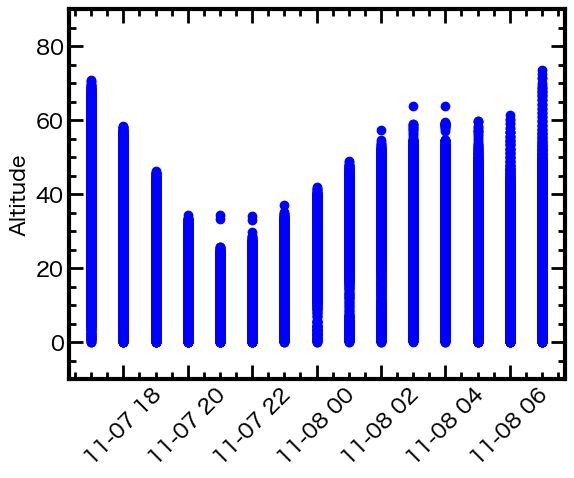

In [4]:
time = datetime(2024, 11, 7, 19, 00) + timedelta(hours=-2)

for i in range(15):
    observables = get_observable_grid(time, alt_min=0, alt_max=90)
    time_values = [time + timedelta(minutes=0) for i in range(len(observables))]
    plt.scatter(time_values, observables["alt"], marker='o', color='b')
    time += timedelta(hours=1)

plt.ylabel("Altitude")
plt.xticks(rotation=45)
plt.minorticks_on()
plt.ylim(-10,90)
plt.show()

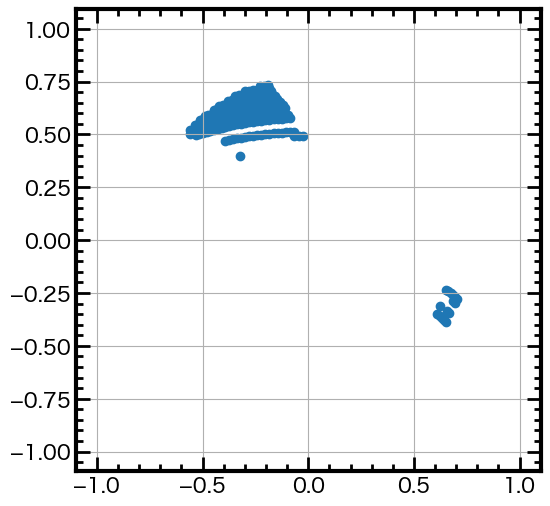

In [5]:
time = datetime.now() + timedelta(hours=-2)
observables = get_observable_grid(time, alt_min=40, alt_max=90)

alt = observables["alt"]
az = observables["az"]

alt_rad = np.radians(alt)
az_rad = np.radians(az)

x = np.cos(alt_rad) * np.sin(az_rad)
y = np.cos(alt_rad) * np.cos(az_rad)

plt.figure(figsize=(6, 6))
plt.scatter(x, y)
plt.grid(True)
plt.axis('equal')
plt.xlim(-1.1,1.1)
plt.ylim(-1.1,1.1)
plt.minorticks_on()
plt.show()